In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random as rand
import numpy as np
import sys
import math
import random
from student_utils import*
from utils import*
np.set_printoptions(threshold=sys.maxsize)

In [2]:
#Graph drawing function:
def drawGraph(G):
    _=drawGraphStructure(G,20,5000)
    return


#draws a graph in the canvas of the notebook
def drawGraphStructure(G,kval,iters):
    pos = nx.spring_layout(G,k = kval/math.sqrt(len(G.nodes())),iterations=iters,scale =2)
    
    nx.draw(G, pos,node_size=1000,node_color = "#d3d3d3",font_size=12, width = 3)
    stupid = nx.draw_networkx_labels(G, pos)
    
    #dumb = nx.draw_networkx_edge_labels(G,pos)
    return pos


def drawAndLabelPathNodes(G,path,position,color,nsize):
    nx.draw_networkx_nodes(G,pos=position,nodelist=path,node_size=nsize,node_color =color, seed = 420)
    pos2 = {}
    for p in position:
        if p in path:
            pos2[p] = position[p]
    G2=nx.Graph()
    G2.add_nodes_from(list(set(path)))
    _=nx.draw_networkx_labels(G2, pos=pos2,nodelist=path, font_size=15,font_color="w")
    

def drawPathEdges(G,path,position,color,lineWidth):
    PathEdges = []
    for i in range(len(path) -1):
        PathEdges.append((path[i],path[i+1]))
    nx.draw_networkx_edges(G,pos=position,edgelist=PathEdges,edge_color=color,width=lineWidth)
        


#Graph drawing function with output drawn in.
def drawSolution(G,carPath,dropLocs):
    print(cost_of_solution(G,carPath,dropLocs)[0])
    print(carPath)
    print(dropLocs)
    plt.figure(figsize=(20,20))
    position = drawGraphStructure(G,20,5000)
    drawAndLabelPathNodes(G,carPath,position,"b",2000)
    drawAndLabelPathNodes(G,[carPath[0]],position,"m",2000)
    drawPathEdges(G,carPath,position,"r",6)
    for dLoc in dropLocs:
        dropOffList = dropLocs[dLoc]
        for dest in dropOffList:
            path = nx.dijkstra_path(G,dLoc,dest)
            drawAndLabelPathNodes(G,path,position,"g",1000)
            drawAndLabelPathNodes(G,[path[0]],position,"y",1000)
            drawPathEdges(G,path,position,"c",2)
    plt.show()


#creates a graph from a list of locations and an edge matrix
def generateLabeledGraph(numLocs,listLocs,adjMatrix):
    #create a new graph
    G,msg = adjacency_matrix_to_graph(adjMatrix)
    #Create dictionary to relabel matrices:
    mapping = {}
    for i in range(len(listLocs)):
        mapping[i] = listLocs[i]
    nx.relabel_nodes(G,mapping,False)
    return G



In [3]:
#Output validating functions
def convertToFile(path, dropoff_mapping, path_to_file, list_locs):
    string = ''
    for node in path:
        string += list_locs[node] + ' '
    string = string.strip()
    string += '\n'

    dropoffNumber = len(dropoff_mapping.keys())
    string += str(dropoffNumber) + '\n'
    for dropoff in dropoff_mapping.keys():
        strDrop = list_locs[dropoff] + ' '
        for node in dropoff_mapping[dropoff]:
            strDrop += list_locs[node] + ' '
        strDrop = strDrop.strip()
        strDrop += '\n'
        string += strDrop
    utils.write_to_file(path_to_file, string)

In [4]:
g50 = "/Users/kristentamsil/Desktop/compSci/cs170/project-fa19/inputs/1_50.in"
g100 = "/Users/kristentamsil/Desktop/compSci/cs170/Project/inputs/100.in"
g200 = "/Users/kristentamsil/Desktop/compSci/cs170/Project/inputs/200.in"

data50 = read_file(g50)

numLocs,numHouses,listLocs,listHouses,startLoc,adjMatrix = data_parser(data50)
G = generateLabeledGraph(numLocs,listLocs,adjMatrix)

In [5]:
def solve(list_of_locations, list_of_homes, starting_car_location, adjacency_matrix, params=[]):
    
    home_indices = convert_locations_to_indices(list_of_homes,list_of_locations)
    start_index = convert_locations_to_indices([starting_car_location],list_of_locations)[0]
    G = adjacency_matrix_to_graph(adjacency_matrix)[0]
    carPath,dropoffs = solverTrialAndError(G,home_indices,start_index,100)
    finaldropoffs = {}
    for dLoc in dropoffs:
        if len(dropoffs[dLoc]) > 0:
            finaldropoffs[dLoc] = dropoffs[dLoc]
    for dLoc in finaldropoffs:
        finaldropoffs[dLoc] = list(set(finaldropoffs[dLoc]))
    return carPath, finaldropoffs



"""
Helper functions for the project
"""

#graph solver function
def solverDijkstraChoices(G,home_indices_master,start_index,choices):
    def pathLength(dest): return nx.dijkstra_path_length(G,currLoc,dest)
    home_indices = home_indices_master[:]
    dropoffs= {}
    currLoc = start_index
    carPath = []
    prevLoc = None
    pathToClosest = None
    returning = False
    while len(home_indices) > 0:
        #Find closest home
        closestHomes = closestNeighbors(G,currLoc,home_indices,choices)
        closest = chooseClosest(G,currLoc,closestHomes)
        intermediate = chokepoint(G,prevLoc,currLoc,closest,carPath,pathToClosest)
        if intermediate is not None:
            pathToClosest = rectifyPath(G,carPath,intermediate,currLoc,closest,dropoffs)
        else:
            pathToClosest = nx.dijkstra_path(G,currLoc, closest)
        carPath.extend(pathToClosest)
        carPath.pop()
        prevLoc = currLoc
        currLoc = closest
        if currLoc in home_indices_master:
            if currLoc in dropoffs:
                dropoffs[currLoc].append(currLoc)
            else:
                dropoffs[currLoc] = [currLoc]
        home_indices.remove(closest)
        if (len(home_indices) <= 0) and not returning:
            home_indices.append(start_index)
            returning=True
    carPath.append(start_index)
    return carPath, dropoffs

def chokepoint(G,prevLoc,currLoc,nextLoc,carPath,pathToCurr):
    if prevLoc == None or pathToCurr == None:
        return
    prevToCurr = pathToCurr
    currToNext = nx.dijkstra_path(G,currLoc, nextLoc)
    for v in prevToCurr:
        intermediate = nx.dijkstra_path(G,v, currLoc)
        if set(intermediate) <= set(currToNext) and len(intermediate) > 1:
            return intermediate[0]

        
def rectifyPath(G,carPath,intermediate,currLoc,nextLoc,dropoffs):
    intStart = intermediate
    dropoffs[currLoc].remove(currLoc)
    if intStart in dropoffs:
        dropoffs[intStart].append(currLoc)
    else:
        dropoffs[intStart] = [currLoc]
    dropoffLoc = carPath.pop()
    while dropoffLoc != intStart:
        dropoffLoc = carPath.pop()
    return nx.dijkstra_path(G,intermediate,nextLoc)
    
    

def solverTrialAndError(G,home_indices_master,start_index,iters):
    home_indices = home_indices_master[:]
    dropoffs = {}
    currLoc = start_index
    carPath = []
    minPath,minDropoffs = solverDijkstraChoices(G,home_indices,start_index,1)
    minCost = cost_of_solution(G,minPath,minDropoffs)[0]
    #Trial and error solver
    prevLoc = None;
    pathToClosest = None;
    for _ in range(iters):
        carPath,dropoffs = solverDijkstraChoices(G,home_indices,start_index,5)
        currCost = cost_of_solution(G,carPath,dropoffs)[0]
        if type(minCost) == type(currCost) and minCost > currCost:
                minPath = carPath
                minDropoffs = dropoffs
        dropoffs = {}
        carPath = []
        home_indices = home_indices_master[:]
        currLoc = start_index
        prevLoc = None;
        pathToClosest = None;
    return minPath,minDropoffs


def chooseClosest(G,currLoc,candidates):
    #make weights for each candidate
    weights = {}
    totalWeight = 0
    if len(candidates) == 1:
        return candidates[0]
    if currLoc in candidates:
        return currLoc
    for v in candidates:
        currWeight = 1/(nx.dijkstra_path_length(G,currLoc,v))
        weights[v] = currWeight
        totalWeight += currWeight
    probList = []
    for v in candidates:
        probList.append(weights[v]/totalWeight)
    return np.random.choice(candidates,p=probList)
        
           
def closestNeighbors(G,currLoc,home_indices,numNeighbors):
    #minKey Lambda
    def pathLength(dest): 
        return nx.dijkstra_path_length(G,currLoc,dest)
    home_indices_temp = home_indices[:]
    closest = []
    for _ in range(numNeighbors):
        currClosest = min(home_indices_temp,key=pathLength)
        closest.append(currClosest)
        home_indices_temp.remove(currClosest)
        if len(home_indices_temp) ==0:
            break
    return closest

In [6]:
#Visualizing the output
def output_and_visualize(listLocs,listHomes,startLoc,adj_matrix):
    path, dropoffs = solve(listLocs,listHomes,startLoc,adj_matrix)
    G = adjacency_matrix_to_graph(adj_matrix)[0]
    drawSolution(G,path,dropoffs)

13108.619333333334
[0, 30, 22, 31, 14, 23, 40, 18, 25, 33, 2, 10, 36, 21, 16, 19, 44, 38, 27, 45, 43, 11, 24, 34, 17, 15, 0]
{0: [0], 30: [30], 22: [22], 31: [31], 14: [14], 23: [23], 40: [40], 18: [18], 25: [25], 33: [33], 2: [2], 10: [10], 36: [36], 21: [21], 16: [16], 19: [19], 44: [44], 38: [38], 27: [27], 45: [45], 43: [43], 11: [11], 24: [24], 34: [34], 15: [15]}


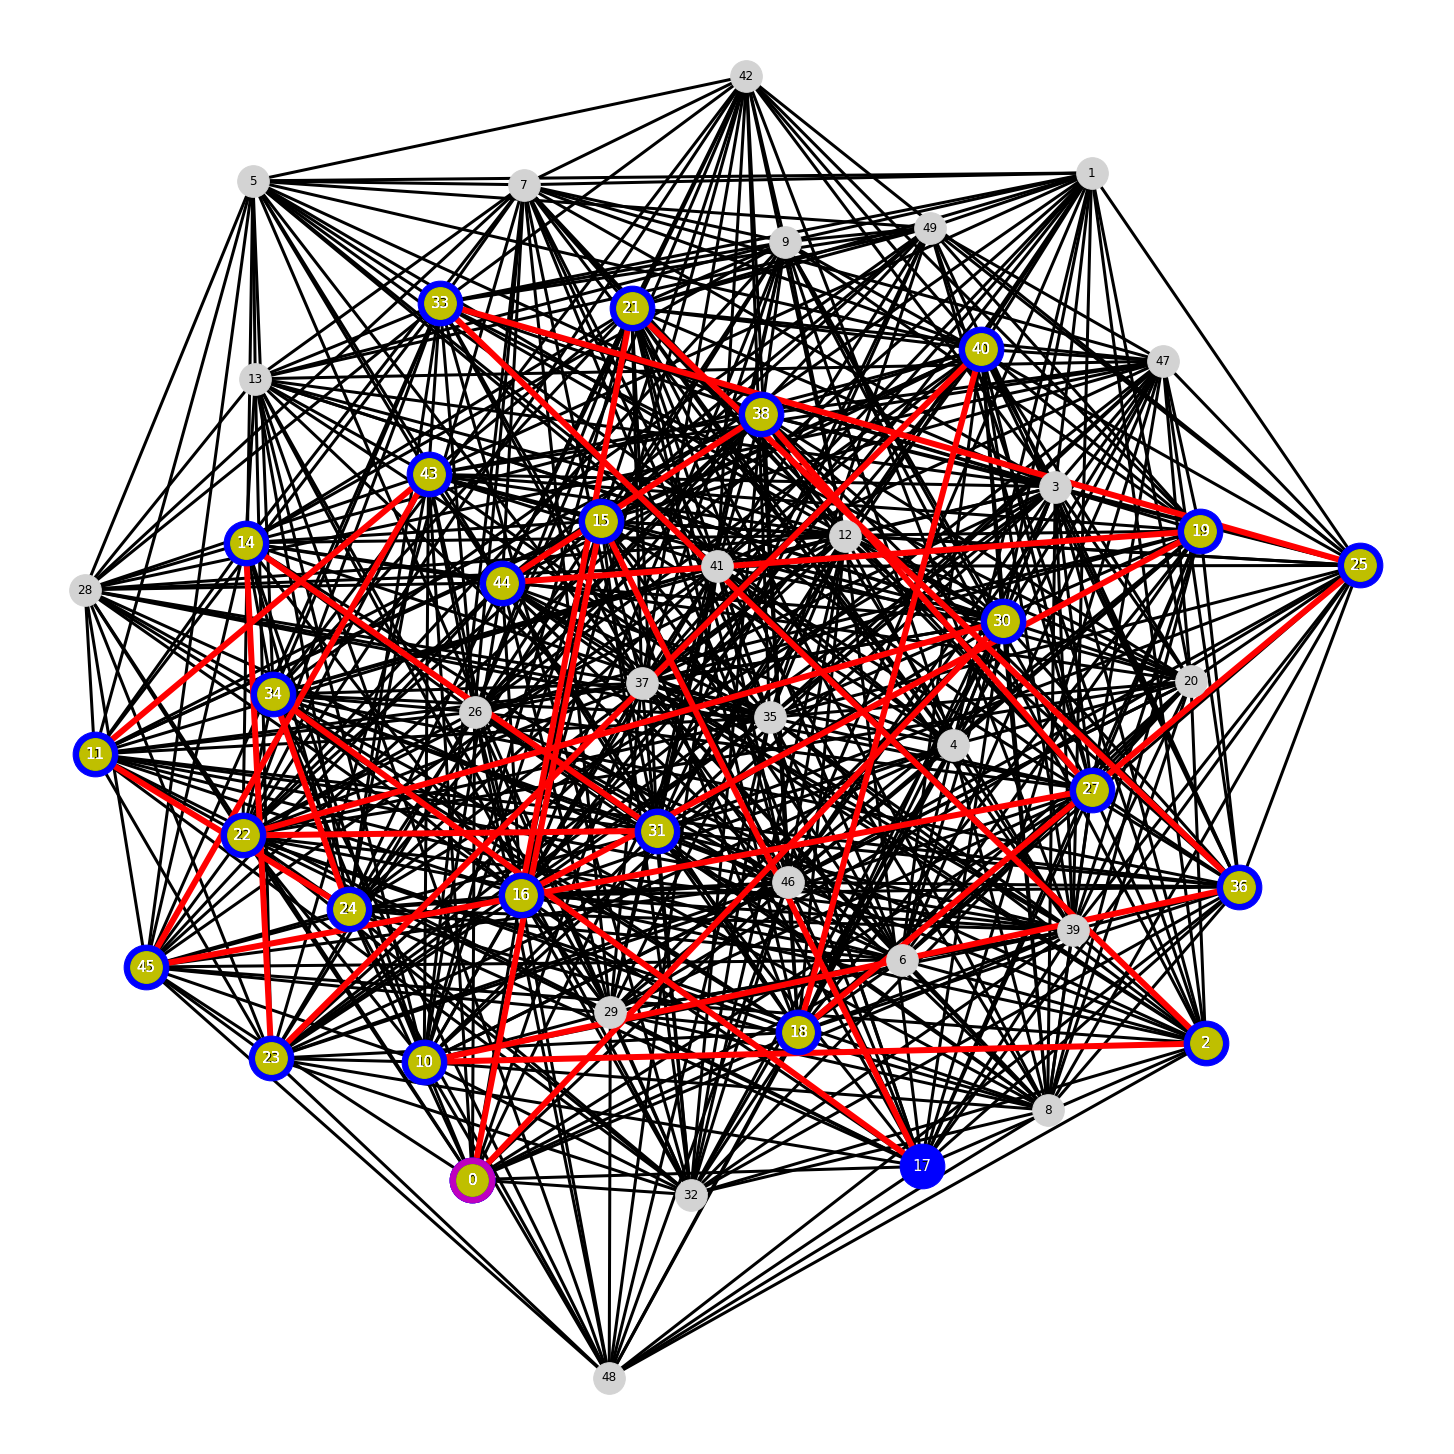

In [7]:
output_and_visualize(listLocs,listHouses,startLoc,adjMatrix)